# **MODELADO PARA EL CLIMA DE LA CIUDAD DE MÉXICO**

http://repositorio.observatoriogeo.mx/dataset/datos-meteorologicos/resource/3b98841a-27c8-4b2c-b1cc-55edf326738c

In [1]:
import pandas as pd
import numpy as np

In [2]:
# import yfinance as yf
# data = yf.Ticker('^GSPC')
# sp = data.history(period='max', auto_adjust=True, actions=False, rounding=True, interval='1d', prepost=False)
# sp.to_csv('sp500.csv', index=True, header=True, sep=',', mode='w')

In [3]:
clima = pd.read_excel('Climatologia-CDMX.xlsx')

In [4]:
clima.columns

Index(['Sta', 'Yr', 'Month', 'DIAS.CON.GRANIZO', 'DIAS.CON.NIEBLA',
       'DIAS.CON.TORMEN.', 'EVAPORACION.MEN.', 'LLUVIA.MAX.24.H.',
       'LLUVIA.TOTAL.MEN', 'TEMP.MAXIMA.EXT.', 'TEMP.MAXIMA.PROM',
       'TEMP.MEDIA.MENS.', 'TEMP.MINIMA.EXT.', 'TEMP.MINIMA.PROM'],
      dtype='object')

In [5]:
temp = clima['TEMP.MEDIA.MENS.']

<Axes: title={'center': 'S&P 500'}, xlabel='Date', ylabel='Price'>

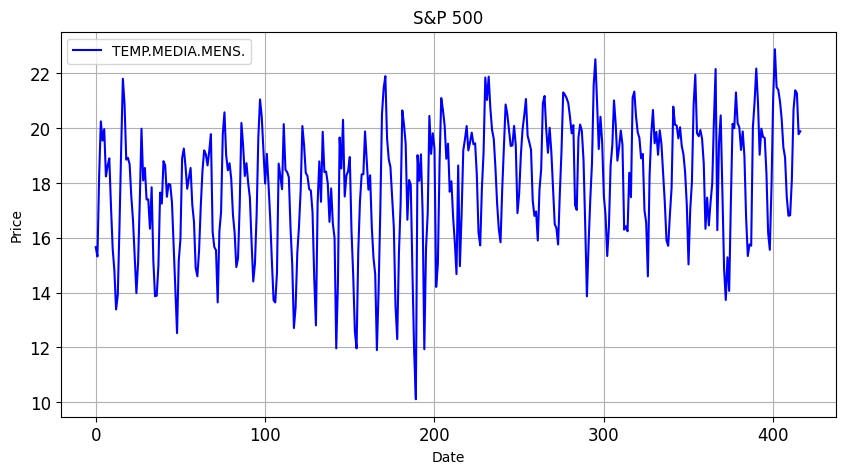

In [6]:
temp.plot(x='Date', y='Close', title='S&P 500', xlabel='Date', ylabel='Price', color='blue', grid=True, legend=True, figsize=(10, 5), fontsize=12)

# **ESTACIONARIEDAD**

In [7]:
from statsmodels.tsa.stattools import adfuller

In [8]:
adfuller(temp)

(-2.2977636841545057,
 0.17269024234890956,
 11,
 405,
 {'1%': -3.446599953548936,
  '5%': -2.86870295908671,
  '10%': -2.570585643956714},
 1346.966751021479)

In [ ]:
# primera diferencia
ntemp = temp.diff().dropna()

In [10]:
adfuller(ntemp)

(-16.235266153466473,
 3.775551409789831e-29,
 10,
 405,
 {'1%': -3.446599953548936,
  '5%': -2.86870295908671,
  '10%': -2.570585643956714},
 1347.475790800609)

la pirmera diferencia es estacionaria, por lo que podemos aplicar el modelo ARIMA

# **AUTOCORRELACIONES**

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf
import matplotlib.pyplot as plt

## **Autocorrelaciones Simples**

In [12]:
# get the autocorrelations
autocorr_values = acf(ntemp, nlags=24)

# drop the first value (lag 0)
autocorr_values = autocorr_values[1:]

print(autocorr_values)

[ 0.11266919 -0.04548276 -0.20904189 -0.24009095 -0.07279592 -0.12399071
 -0.05386207 -0.22610682 -0.13595006  0.11315062  0.23367982  0.38676276
  0.17570023  0.03929149 -0.17941815 -0.16517471 -0.0964692  -0.05494101
 -0.12744225 -0.17467073 -0.046766    0.11019434  0.19504103  0.32562699]


In [13]:
def significancia(N, d, rho_list):
    """Calculate the significance threshold from a list of rho values."""
    return 2 * np.sqrt(1 / (N - d) * (1 + 2 * sum(rho**2 for rho in rho_list)))

In [14]:
def FAC(N, d, r_list):
    """
    Check the significance of a list of autocorrelation values.
    For each value in r_list, update the corresponding rho value if its absolute
    value exceeds the significance threshold computed from the current rho list.

    If rho_list is not provided, it defaults to a list of zeros (same length as r_list).

    Returns the updated list of rho values.
    """
    significativos = []
    rho_list = [0] * len(r_list)
    
    updated_rhos = list(rho_list)  # Copy to retain original values when updating
    for i, r in enumerate(r_list):
        threshold_value = significancia(N, d, updated_rhos)
        if abs(r) > threshold_value:
            print(f"rho {i+1} es significativo")
            print(f"{abs(r)} > {threshold_value}\n")
            updated_rhos[i] = r
            significativos.append((r, i+1))
        else:
            print(f"rho {i+1} no es significativo")
            print(f"{abs(r)} < {threshold_value}\n")
    return updated_rhos, significativos

# Example usage
N = len(ntemp)
d = 0

ceros = len(autocorr_values)
rho_list = [0] * ceros

val_autocorr_sig, autocorr_sig = FAC(N, d, autocorr_values) # Valores de autocorrelacion significativos, Autocorrelaciones significativas

rho 1 es significativo
0.1126691917970298 > 0.09805806756909202

rho 2 no es significativo
0.045482755329313854 < 0.09929504856159707

rho 3 es significativo
0.20904188936667412 > 0.09929504856159707

rho 4 es significativo
0.24009094609775714 > 0.10344014046503722

rho 5 no es significativo
0.0727959165834827 < 0.10866643745251416

rho 6 es significativo
0.12399071124476889 > 0.10866643745251416

rho 7 no es significativo
0.05386206509966341 < 0.11001837409158287

rho 8 es significativo
0.22610682403985644 > 0.11001837409158287

rho 9 es significativo
0.13595006271763316 > 0.11439931019835363

rho 10 no es significativo
0.11315062081179522 < 0.11594237068090234

rho 11 es significativo
0.23367981776438648 > 0.11594237068090234

rho 12 es significativo
0.386762760759224 > 0.12038585319904306

rho 13 es significativo
0.17570023244103208 > 0.1317930066235932

rho 14 no es significativo
0.03929148650996739 < 0.13402634604764566

rho 15 es significativo
0.17941815270168 > 0.134026346047645

In [15]:
val_autocorr_sig

[0.1126691917970298,
 0,
 -0.20904188936667412,
 -0.24009094609775714,
 0,
 -0.12399071124476889,
 0,
 -0.22610682403985644,
 -0.13595006271763316,
 0,
 0.23367981776438648,
 0.386762760759224,
 0.17570023244103208,
 0,
 -0.17941815270168,
 -0.1651747058654187,
 0,
 0,
 0,
 -0.1746707329356797,
 0,
 0,
 0.19504103413147086,
 0.3256269900172247]

In [16]:
print("Valores de autocorrelacion significativos:")
for val, i in autocorr_sig:
    print(f"r{i}: {val}")

Valores de autocorrelacion significativos:
r1: 0.1126691917970298
r3: -0.20904188936667412
r4: -0.24009094609775714
r6: -0.12399071124476889
r8: -0.22610682403985644
r9: -0.13595006271763316
r11: 0.23367981776438648
r12: 0.386762760759224
r13: 0.17570023244103208
r15: -0.17941815270168
r16: -0.1651747058654187
r20: -0.1746707329356797
r23: 0.19504103413147086
r24: 0.3256269900172247


## Autocorrelaciones Simples

In [17]:
pacf_values = pacf(ntemp, nlags=24)

# drop the first value (lag 0)
pacf_values = pacf_values[1:]

print(pacf_values)

[ 0.11294068 -0.05921338 -0.20167605 -0.2104048  -0.05678961 -0.19561413
 -0.15570689 -0.38596889 -0.37489725 -0.25560791 -0.23488184 -0.04092434
 -0.05865484  0.01047636 -0.10157664 -0.06099318 -0.06318612  0.04154766
 -0.06995502 -0.11526209 -0.09298975 -0.06225194 -0.15000078  0.02109065]


In [18]:
def intervalo(N, d):
    "Esta es de las autocorrelaciones parciales"
    return 2*np.sqrt(1/ (N-d) )

In [19]:
def FACP(N, d, rho_list):
    """
    Check the significance of a list of autocorrelation values.
    For each value in rho_list, update the corresponding rho value if its absolute
    value exceeds the significance threshold computed from the current rho list.

    If rho_list is not provided, it defaults to a list of zeros (same length as r_list).

    Returns the updated list of rho values.
    """
    
    threshold_value = intervalo(N, d)
    significativos = []
    print(f"Intervalo de confianza: {threshold_value}\n")

    for i, r in enumerate(rho_list):
        
        if abs(r) > threshold_value:
            print(f"rho {i+1} es significativo, {abs(r)}\n")
            significativos.append((r, i+1))
        else:
            print(f"rho {i+1} no es significativo, {abs(r)}\n")
    
    return significativos

In [20]:
# Example usage
N = len(ntemp)
d = 0

ceros = len(pacf_values)
rho_list = [0] * ceros 

facp_sig = FACP(N, d, pacf_values)

Intervalo de confianza: 0.09805806756909202

rho 1 es significativo, 0.11294068382545636

rho 2 no es significativo, 0.05921337890928947

rho 3 es significativo, 0.20167604511944676

rho 4 es significativo, 0.21040480435465872

rho 5 no es significativo, 0.05678961364718659

rho 6 es significativo, 0.19561412744347664

rho 7 es significativo, 0.15570688915786354

rho 8 es significativo, 0.3859688891027393

rho 9 es significativo, 0.37489725475476493

rho 10 es significativo, 0.25560791477511463

rho 11 es significativo, 0.23488184392372485

rho 12 no es significativo, 0.040924339342648657

rho 13 no es significativo, 0.05865483847735918

rho 14 no es significativo, 0.010476357429044148

rho 15 es significativo, 0.10157664448911136

rho 16 no es significativo, 0.06099318183711591

rho 17 no es significativo, 0.0631861236125447

rho 18 no es significativo, 0.04154765566941521

rho 19 no es significativo, 0.0699550159690226

rho 20 es significativo, 0.115262087224301

rho 21 no es signifi

In [21]:
print(f"Valores de autocorrelacion parcial significativos:")
for r, i in facp_sig:
    print(f"rho {i}: {r}")

Valores de autocorrelacion parcial significativos:
rho 1: 0.11294068382545636
rho 3: -0.20167604511944676
rho 4: -0.21040480435465872
rho 6: -0.19561412744347664
rho 7: -0.15570688915786354
rho 8: -0.3859688891027393
rho 9: -0.37489725475476493
rho 10: -0.25560791477511463
rho 11: -0.23488184392372485
rho 15: -0.10157664448911136
rho 20: -0.115262087224301
rho 23: -0.15000077810465898


## plot

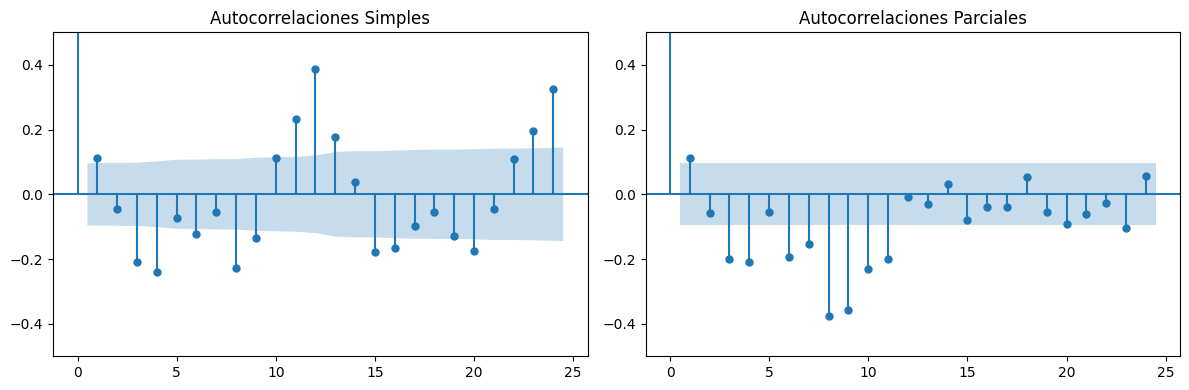

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(ntemp, lags=24, ax=axs[0])
axs[0].set_ylim(-0.5, 0.5)
axs[0].set_title('Autocorrelaciones Simples')

plot_pacf(ntemp, lags=24, ax=axs[1])
axs[1].set_ylim(-0.5, 0.5)
axs[1].set_title('Autocorrelaciones Parciales')

plt.tight_layout()
plt.show()


In [23]:
print("Valores de autocorrelacion significativos:")
for val, i in autocorr_sig:
    print(f"r{i}: {val}")

Valores de autocorrelacion significativos:
r1: 0.1126691917970298
r3: -0.20904188936667412
r4: -0.24009094609775714
r6: -0.12399071124476889
r8: -0.22610682403985644
r9: -0.13595006271763316
r11: 0.23367981776438648
r12: 0.386762760759224
r13: 0.17570023244103208
r15: -0.17941815270168
r16: -0.1651747058654187
r20: -0.1746707329356797
r23: 0.19504103413147086
r24: 0.3256269900172247


In [24]:
print(f"Valores de autocorrelacion parcial significativos:")
for r, i in facp_sig:
    print(f"rho {i}: {r}")

Valores de autocorrelacion parcial significativos:
rho 1: 0.11294068382545636
rho 3: -0.20167604511944676
rho 4: -0.21040480435465872
rho 6: -0.19561412744347664
rho 7: -0.15570688915786354
rho 8: -0.3859688891027393
rho 9: -0.37489725475476493
rho 10: -0.25560791477511463
rho 11: -0.23488184392372485
rho 15: -0.10157664448911136
rho 20: -0.115262087224301
rho 23: -0.15000077810465898


# **MODELADO**

In [61]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [62]:
# Convert your raw series to have a DatetimeIndex
date_index = pd.date_range(start='1982-01-01', periods=len(temp), freq='MS')
temp.index = date_index

In [63]:
# Define training and test sets using the updated index
train = temp.iloc[:-12]
test = temp.iloc[-12:]

In [66]:
# Define and fit the SARIMAX model using the datetime-indexed training set
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
result = model.fit()

In [67]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   TEMP.MEDIA.MENS.   No. Observations:                  405
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -694.259
Date:                            Sun, 06 Apr 2025   AIC                           1398.519
Time:                                    02:44:36   BIC                           1418.375
Sample:                                01-01-1982   HQIC                          1406.388
                                     - 09-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5325      0.034     15.587      0.000       0.466       0.599
ma.L1         -0.9999      0.569     -1.757      0.079      -2.115       0.116
ar.S.L12       0.1190      0.080      1.490      0.136      -0.038       0.276
ma.S.L12      -0.7220      0.060    -11.978      0.000      -0.840      -0.604
sigma2         1.9527      1.110      1.758      0.079      -0.224       4.129
===================================================================================
Ljung-Box (L1) (Q):                   2.26   Jarque-Bera (JB):               377.50
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                             0.19
Prob(H) (two-sided):                  0.08   Kurtosis:                         7.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

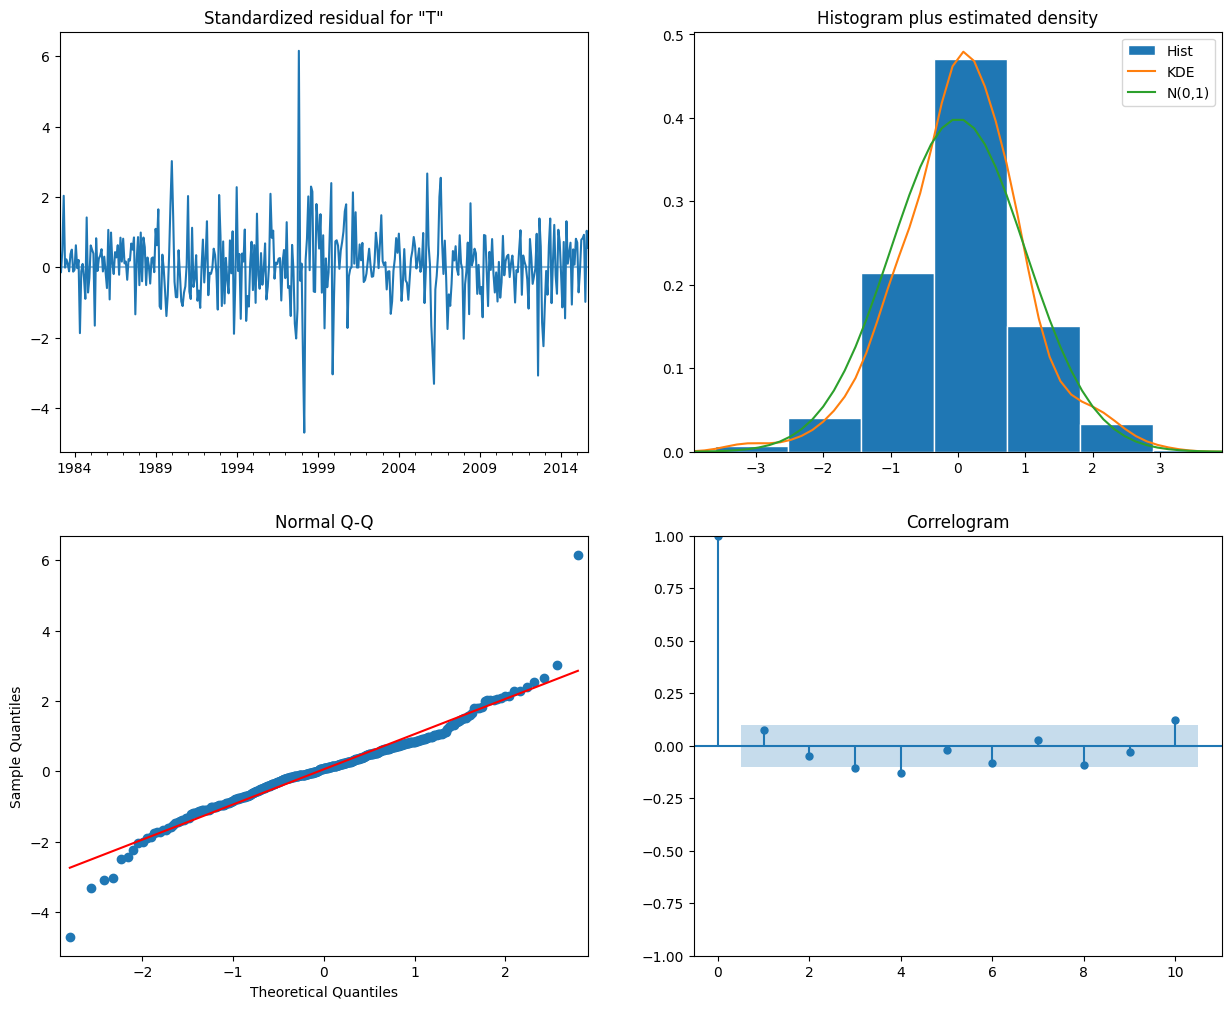

In [68]:
plot = result.plot_diagnostics(figsize=(15, 12))

c:\Users\herie\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: >

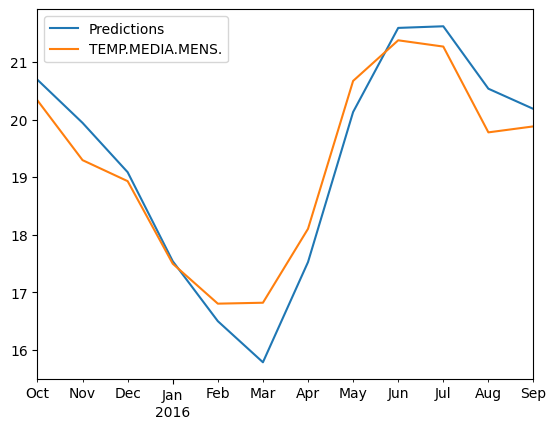

In [69]:
start = len(train)
end = len(train) + len(test) - 1

# predictions for one-year against the test set
predictions = result.predict(start, end, typ = 'levels').rename('Predictions')

# plot the predictions against the test set
predictions.plot(legend = True)
test.plot(legend = True)

In [74]:
# Load specific evaluation tools 
from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse 

In [ ]:
# Calculate root mean squared error 
rmse(test, predictions) 


0.5166429426550524

In [71]:
# Calculate mean squared error 
mean_squared_error(test, predictions) 

0.26691993019527177

# el bueno

In [79]:
# Define and fit the SARIMAX model using the datetime-indexed training set
model = SARIMAX(temp, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
result = model.fit()

In [85]:
# Predecir los próximos 36 meses
forecast_steps = 36
forecast = result.get_forecast(steps=forecast_steps)

# Obtener las predicciones
forecast_values = forecast.predicted_mean

# Mostrar las predicciones y los intervalos de confianza
print("Predicciones para los próximos 12 meses:")
print(forecast_values)

Predicciones para los próximos 12 meses:
2016-10-01    19.951292
2016-11-01    19.378303
2016-12-01    18.801524
2017-01-01    17.367392
2017-02-01    16.653998
2017-03-01    16.243809
2017-04-01    17.747455
2017-05-01    20.261692
2017-06-01    21.395772
2017-07-01    21.542745
2017-08-01    20.179705
2017-09-01    20.017310
2017-10-01    20.066581
2017-11-01    19.496093
2017-12-01    18.865278
2018-01-01    17.416059
2018-02-01    16.692236
2018-03-01    16.226380
2018-04-01    17.754076
2018-05-01    20.260371
2018-06-01    21.445381
2018-07-01    21.622852
2018-08-01    20.275046
2018-09-01    20.080452
2018-10-01    20.127861
2018-11-01    19.557647
2018-12-01    18.920306
2019-01-01    17.469261
2019-02-01    16.744176
2019-03-01    16.271611
2019-04-01    17.802203
2019-05-01    20.307540
2019-06-01    21.498688
2019-07-01    21.679833
2019-08-01    20.333863
2019-09-01    20.135389
Freq: MS, Name: predicted_mean, dtype: float64


In [81]:
# Obtener los intervalos de confianza (por ejemplo, al 95%)
conf_int = forecast.conf_int(alpha=0.05)

print("\nIntervalos de confianza (95%) para los próximos 12 meses:")
print(conf_int)


Intervalos de confianza (95%) para los próximos 12 meses:
            lower TEMP.MEDIA.MENS.  upper TEMP.MEDIA.MENS.
2016-10-01               17.246771               22.655812
2016-11-01               16.310313               22.446292
2016-12-01               15.636098               21.966950
2017-01-01               14.173861               20.560923
2017-02-01               13.452007               19.855989
2017-03-01               13.039139               19.448479
2017-04-01               14.541875               20.953034
2017-05-01               17.055774               23.467610
2017-06-01               18.189715               24.601828
2017-07-01               18.336626               24.748864
2017-08-01               16.973556               23.385853
2017-09-01               16.811146               23.223474
2017-10-01               16.681400               23.451762
2017-11-01               16.060009               22.932177
2017-12-01               15.413930               22.3166

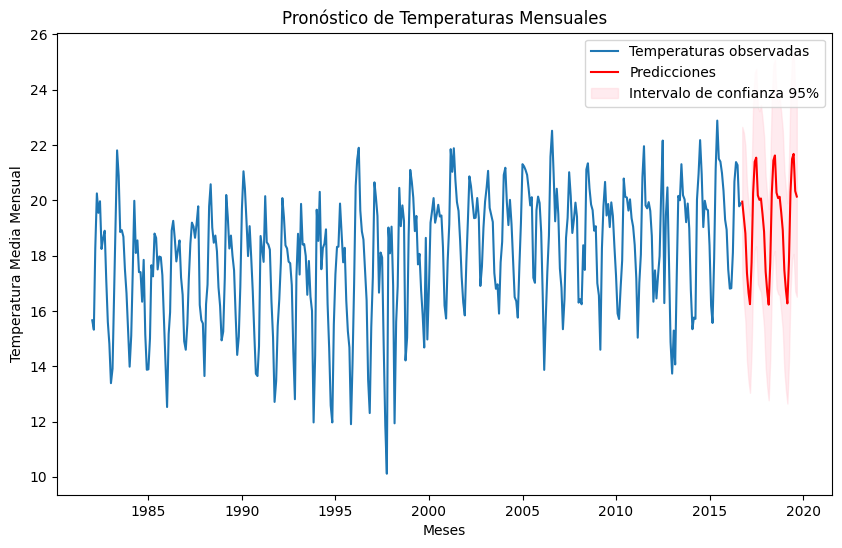

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Graficar las predicciones y los intervalos de confianza
plt.figure(figsize=(10, 6))

# Graficar la serie original
plt.plot(temp, label='Temperaturas observadas')

# Graficar las predicciones
plt.plot(forecast_values.index, forecast_values, label='Predicciones', color='red')

# Graficar los intervalos de confianza
plt.fill_between(forecast_values.index, 
                 conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Intervalo de confianza 95%')

plt.legend()
plt.title('Pronóstico de Temperaturas Mensuales')
plt.xlabel('Meses')
plt.ylabel('Temperatura Media Mensual')
plt.show()

plt.gcf().autofmt_xdate()